In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

C:\Users\jiajunshuang\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Read data from file 'spx.csv'
data = pd.read_csv('spx.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


In [3]:
# We just want to focus on data after crisis, which is approximately after 1/1/2009
data = data['20090101':]
data.tail()

,close
date,
2018-06-25,2717.07
2018-06-26,2723.06
2018-06-27,2699.63
2018-06-28,2716.31
2018-06-29,2718.37


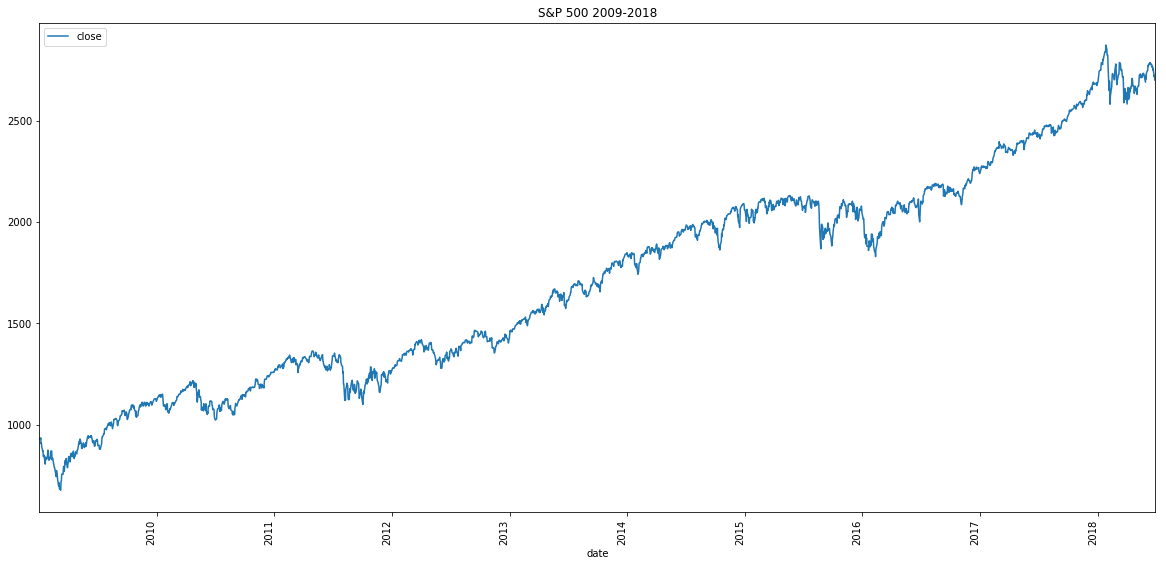

In [4]:
data.plot(title='S&P 500 2009-2018', kind='line', y='close')
plt.xticks(rotation=90)
plt.gcf().set_size_inches(20, 10)

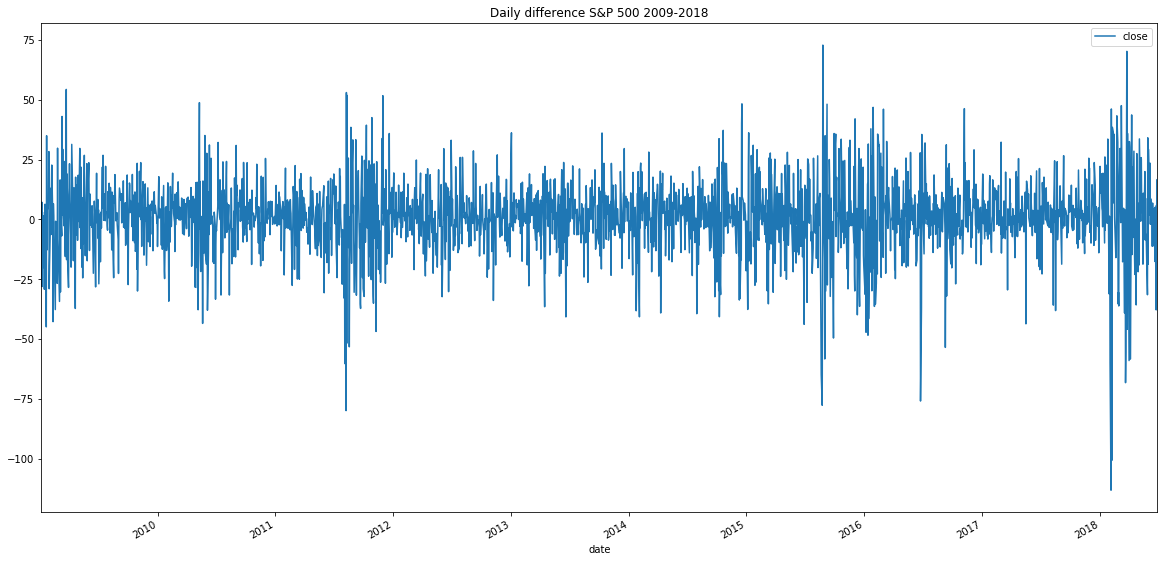

In [11]:
# It seems like a non-stationary upward trending time series
# Let's take a look at daily difference of this time series
diff1 = data.diff()
diff1.dropna(inplace=True)
diff1.plot(title='Daily difference S&P 500 2009-2018', kind='line', y='close')
plt.gcf().set_size_inches(20, 10)

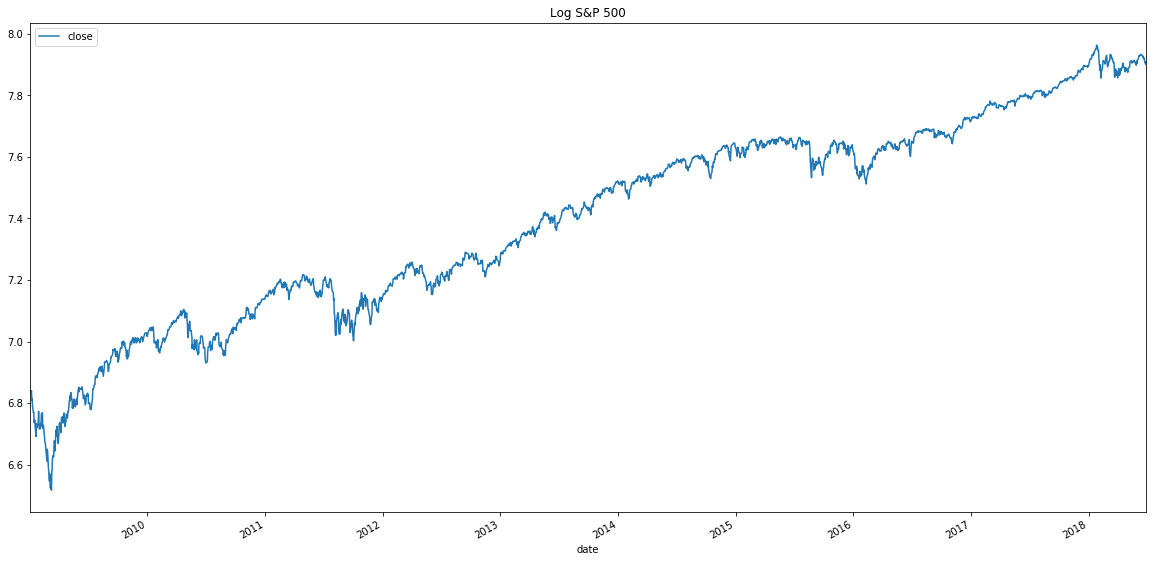

In [6]:
# Let's take a log and see how it will change
data_log = np.log(data)
data_log.plot(title='Log S&P 500')
plt.gcf().set_size_inches(20, 10)

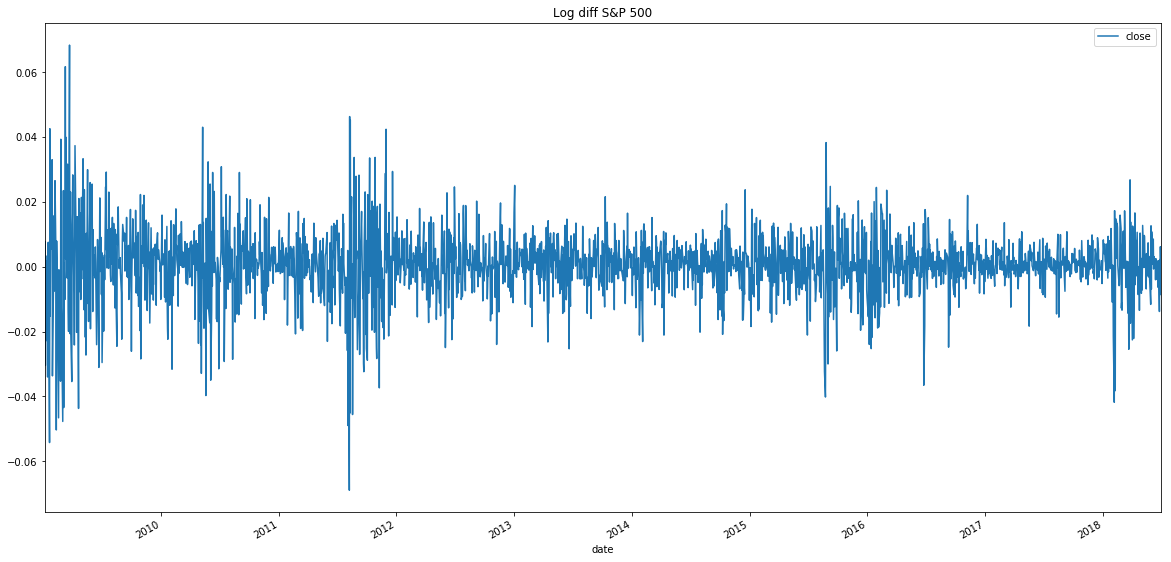

In [12]:
diff1_log = data_log.diff()
diff1_log.dropna(inplace=True)
diff1_log.plot(title='Log diff S&P 500')
plt.gcf().set_size_inches(20, 10)

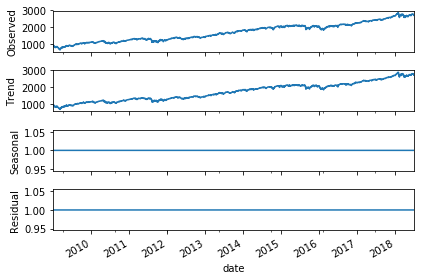

In [8]:
# We want to know if the S&P 500 time series is stationary or not
# One approximate way to do this is to visualize it by decomposing S&P500 time series into trend, seasonal and residual parts
# If both trend and seasonality effects are not significant from the graph, then we can day this time series is stationary
decomposition = sm.tsa.seasonal_decompose(data, model='multiplicative', freq=1)
fig = decomposition.plot()

# Turns out there is no seasonality but significant upward trend can be observed from the graph, thus we may assume it is not stationary

In [13]:
# Let's take a Augmented Dickey-Fuller test on both diff time series to see if the null hypothesis can be rejected
for df in [diff1, diff1_log]:
    adf_test = sm.tsa.stattools.adfuller(df['close'])
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))
    

ADF Statistic: -23.563548
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -10.960497
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


We observed both ADF stats is smaller than 1% critical values, which means we can reject the null hypothesis at 99% confidence level that it has unit root. So they are both stationary process. Let's focus on diff1 for now.

In [17]:
# In order to use ARIMA method to predict this stationary time series, we need to determined p, q and d parameters
# We first plot ACF and PACF to see if it can give us estimate on p and q
diff_acf = sm.tsa.stattools.acf(diff1, nlags=20)
diff_pacf = sm.tsa.stattools.pacf(diff1, nlags=20, method='ols')

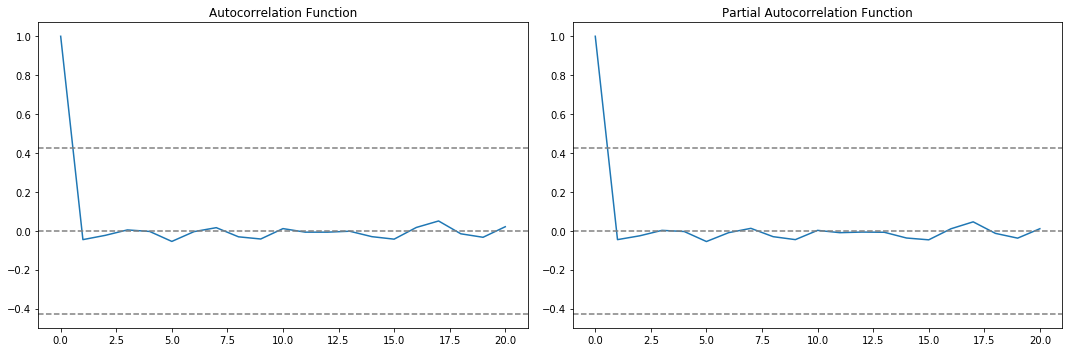

In [22]:
# Plot ACF and PACF
plt.subplot(121)
plt.plot(diff_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_acf)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_acf)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(diff_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_acf)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_acf)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

plt.gcf().set_size_inches(15, 5)
plt.tight_layout()

p--the lag value where the PACF chart crosses the upper confidence interval for the first time, in this case p = 1
q--the lag value where the ACF chart crosses the upper confidence interval for the first time, in this case q = 1
This is also intuitive in financial market: the most relevant previous number to today number D(t) is D(t-1)

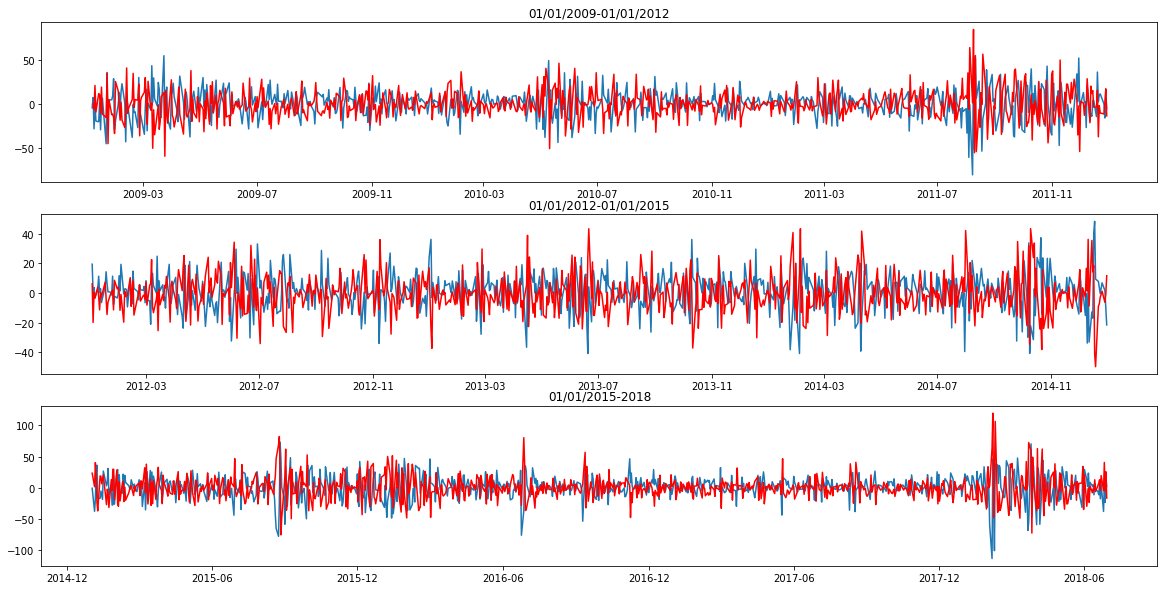

In [52]:
# Fit the ARIMA model
model = sm.tsa.ARIMA(diff1, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=1)

diff1_1 = diff1[:'20120101']
diff1_2 = diff1['20120101':'20150101']
diff1_3 = diff1['20150101':]

results_1 = results_ARIMA.fittedvalues[:'20120101']
results_2 = results_ARIMA.fittedvalues['20120101':'20150101']
results_3 = results_ARIMA.fittedvalues['20150101':]

plt.subplot(311)
plt.plot(diff1_1)
plt.plot(results_1, color='red')
plt.title('01/01/2009-01/01/2012')
plt.gcf().set_size_inches(20, 10)

plt.subplot(312)
plt.plot(diff1_2)
plt.plot(results_2, color='red')
plt.title('01/01/2012-01/01/2015')
plt.gcf().set_size_inches(20, 10)

plt.subplot(313)
plt.plot(diff1_3)
plt.plot(results_3, color='red')
plt.title('01/01/2015-2018')
plt.gcf().set_size_inches(20, 10)

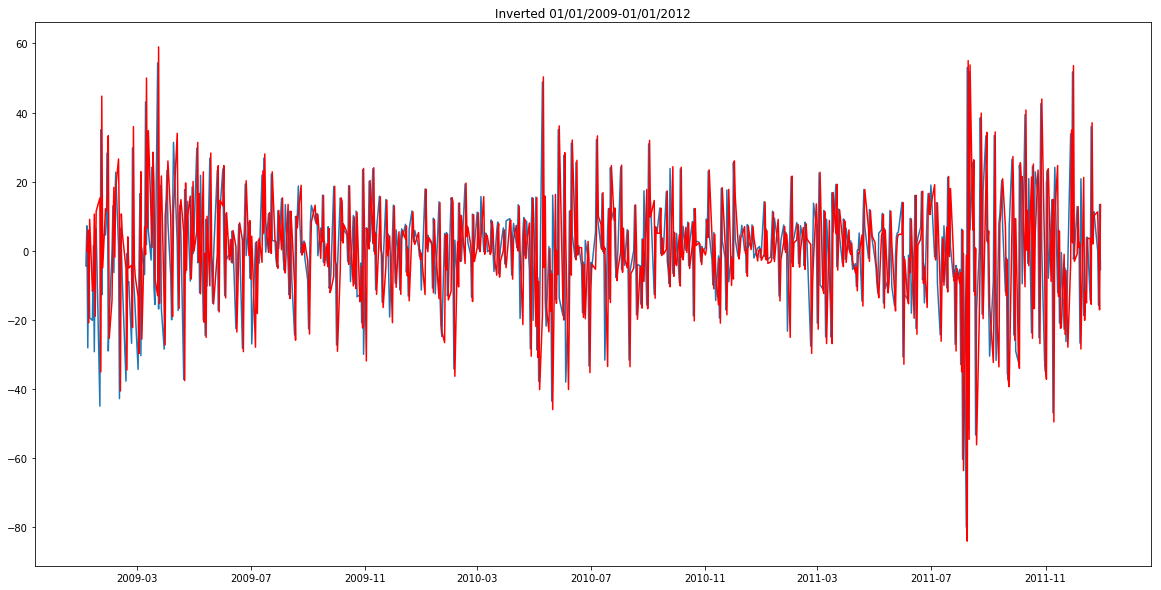

In [56]:
#We noticed the fitted plots are inverted to the original plot, so we mannually invert the fitted plot and it seems
# perfectly fit
results_1.loc[:] *= -1
plt.plot(diff1_1)
plt.plot(results_1, color='red')
plt.title('Inverted 01/01/2009-01/01/2012')
plt.gcf().set_size_inches(20, 10)